In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_cosmology import p
from dset import get_dataloader, load_pretrained_model
from dset import get_validation

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun, low_to_high
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# peakcounting
from peak_counting import PeakCount, ModelPred, rmse

In [2]:
# get dataloader and model
train_loader, test_loader = get_dataloader(p.data_path, 
                                           img_size=p.img_size[2],
                                           split_train_test=True,
                                           batch_size=p.batch_size) 

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)    

# used for cross-validation
val_loader = get_validation(p.data_path, 
                            img_size=p.img_size[2],
                            batch_size=p.batch_size)

# load results

In [3]:
# wavelet params
waves = ["db5"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT2d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [4]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT2d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        if lamL1attr_grid[c] <= 0.1:
            loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
            if loc.sum() == 1: 
                loc = np.argwhere(loc).flatten()[0]
                dic['index'][(r,c)] = loc
                wt = mos[loc]
                _, psi, x = get_wavefun(wt)

                dic['wt'][(r,c)] = wt
                dic['psi'][(r,c)] = psi     
                dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
                dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]


# extract kernels

In [5]:
def extract_patches(h, g, centering=True):
    """Given 1-d filters h, g, extract 3x3 LH,HL,HH filters with largest variation
    """
    hc = h - h.mean()
    var = []
    for left in range(len(h)-3):
        v = torch.sum((hc[left:left+3])**2)
        var.append(v)
    var = np.array(var)
    h_small = h[np.argmax(var):np.argmax(var)+3]
    
    gc = g - g.mean()
    var = []
    for left in range(len(g)-3):
        v = torch.sum((gc[left:left+3])**2)
        var.append(v)
    var = np.array(var)
    g_small = g[np.argmax(var):np.argmax(var)+3]
    
    ll = h_small.unsqueeze(0)*h_small.unsqueeze(1)
    lh = h_small.unsqueeze(0)*g_small.unsqueeze(1)
    hl = g_small.unsqueeze(0)*h_small.unsqueeze(1)
    hh = g_small.unsqueeze(0)*g_small.unsqueeze(1)
    
    if centering:
        lh -= lh.mean()
        hl -= hl.mean()
        hh -= hh.mean()
    
    return [ll, lh, hl, hh]

In [6]:
kern_list = []
for wt in [wt_o] + list(dic['wt'].values()):
    filt = get_2dfilts(wt)
    h = filt[0][0]
    g = filt[0][1]
    kern_list.append(extract_patches(h, g))


# peak counting methods

In [7]:
bds = np.linspace(0.01,0.04,10)
scores = np.zeros((len(bds), len(kern_list)))

for i,b in tqdm(enumerate(bds), total=len(bds)):
    for j,kernels in tqdm(enumerate(kern_list), total=len(kern_list)):
        pcw = PeakCount(peak_counting_method='custom', 
                        bins=np.linspace(0,b,23),
                        kernels=kernels)
        pcw.fit(train_loader)
        y_preds, y_params = pcw.predict(test_loader)
        scores[i,j] = rmse(y_params, y_preds)
        pkl.dump(scores, open('results/scores.pkl', 'wb'))  
print(np.min(scores))

100%|██████████| 10/10 [14:18:15<00:00, 5149.59s/it] 

0.00011913597674074962


# Optimal filter

In [8]:
# optimal wavelet using cross-validation
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dic['wt'].keys())[col-1]
wt = dic['wt'][(idx1, idx2)]

In [9]:
filt = get_2dfilts(wt)
h = filt[0][0]
g = filt[0][1]
kernels = extract_patches(h, g)
pcw = PeakCount(peak_counting_method='custom', 
                bins=np.linspace(0,bd_opt,23),
                kernels=kernels)
pcw.fit(train_loader)
y_preds, y_params = pcw.predict(val_loader)
print(rmse(y_params, y_preds))

0.00010680186019861362


Hyperparameter: lamL1wave=0.013570 lamL1attr=0.006950
Error: Recon=0.008835
Sparsity: Wave=96.029034
Interp: Saliency=111.674630 InputXGrade=0.816898
Wavelet loss: lSum=0.000000 hsum=0.000000 L2norm=0.000018 CMF=0.001244 Conv=0.000067


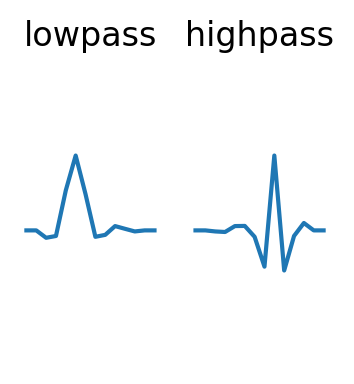

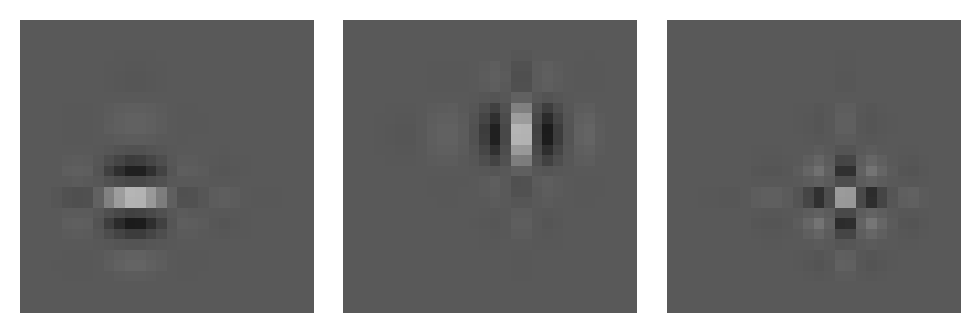

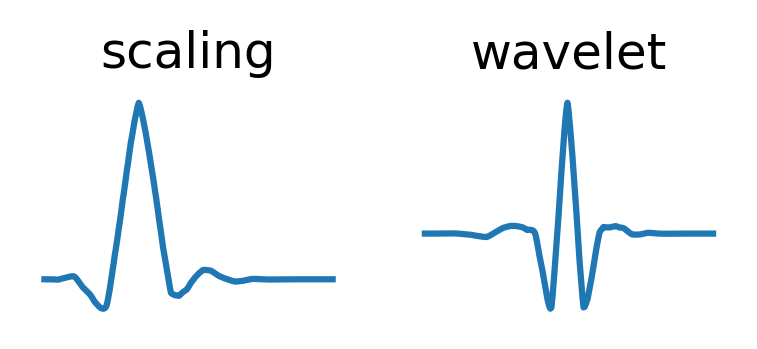

In [11]:
filt = get_2dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][dic['index'][(idx1, idx2)]], res['lamL1attr'][dic['index'][(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][dic['index'][(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][dic['index'][(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][dic['index'][(idx1, idx2)]], res['L1inputxgrad_loss'][dic['index'][(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['hsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['L2norm_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['CMF_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['conv_loss'][dic['index'][(idx1, idx2)]]))


# plot filters
plot_1dfilts(filt[0], is_title=True, figsize=(2,2))
plot_2dfilts(filt[1], figsize=(5,5))
plot_wavefun(get_wavefun(wt), is_title=True, figsize=(3,1))